# Integral action

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The theory of everything is not found yet, so our model is **always** terrible*

Most likely the model we have is not a perfect representation of the real world. "Neglect air friction, neglect static/dynamic friction and hysteresis, assume rigid bodies, assume perfect efficiency, ..." All lies we tell ourselves to make our lives easier and to blind ourselves to the harsh reality.

So if out model is incorrect, what does that mean for our controller? Simply said, it's not exactly what we want, but *it's close*. To get it perfect however, we need to add an output feedback part to our state feedback controller. An integrator of the reference-output-error to be precise. This integrator wil drive the integral of the error, $z$, to zero, meaning that the error will be zero. I'll stop talking now and show the block diagram so you actually understand.

![Integral action](../figures/IntActCL.svg)

Sooooo maths time. Substitute everything into everything, yada yada, this is largely what control engineers do. Also assume D=0. Lets start with plant equations and work our way backwards through the block diagram.
$$\left\{\begin{aligned}\dot x &= Ax + Bu = Ax + B(k_fr-Kx-k_iz) = (A-BK)x + Bk_fr-Bk_iz \\ y &= Cx\end{aligned}\right.$$
and
$$\dot z = y - r = Cx - r.$$
Augmenting (stacking) the $x$ and $z$ dynamics gives the nice expression
$$\left\{\begin{aligned}\begin{bmatrix}\dot x\\\dot z\end{bmatrix} &= \begin{bmatrix}(A-BK) & -Bk_i\\ C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix} + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix}.\end{aligned}\right.$$
Saying $q = \begin{bmatrix} x\\ z\end{bmatrix}$ gives the new state space representation
$$\left\{\begin{aligned}\dot q &= \begin{bmatrix}(A-BK) & -Bk_i\\ C&0\end{bmatrix}q + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}q.\end{aligned}\right.$$

Note that the integral error is independent from $A$, so however bad our modeling mistakes are, the integral action will fix it (as long as it's stable). First however, lets look at the nominal behaviour.

In [7]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

import scipy.signal as signal
import scipy.linalg as sclin
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()

P_reg = cm.ss(cm.zpk(zeros=[-3], 
                     poles=cm.rss(5).poles(), 
                     gain=1, dt=0))
nx_reg = len(P_reg.poles())
x0_reg = rng.randn(nx_reg,1)

T_reg = np.arange(500)*0.05

assert isControlable(P_reg.A, P_reg.B)==True, "System is uncontrollable D:"

CLpoles_reg = np.linspace(-2, -6, nx_reg)
K_reg = cm.place(P_reg.A, P_reg.B, CLpoles_reg)
CL_reg = cm.ss(P_reg.A-P_reg.B@K_reg, 
                np.zeros([nx_reg,1]), 
                P_reg.C, 
                P_reg.D)

forced_reg = cm.forced_response(sysdata=CL_reg, 
                                T=T_reg, 
                                X0=x0_reg)

kf_ref = (-1/(P_reg.C@lin.inv(P_reg.A - P_reg.B@K_reg)@P_reg.B))[0,0]

CL_ref = cm.ss(P_reg.A-P_reg.B@K_reg, 
               P_reg.B*kf_ref, 
               P_reg.C, 
               P_reg.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=sqr_ref)
response_saw_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=saw_ref)


<IPython.core.display.Javascript object>

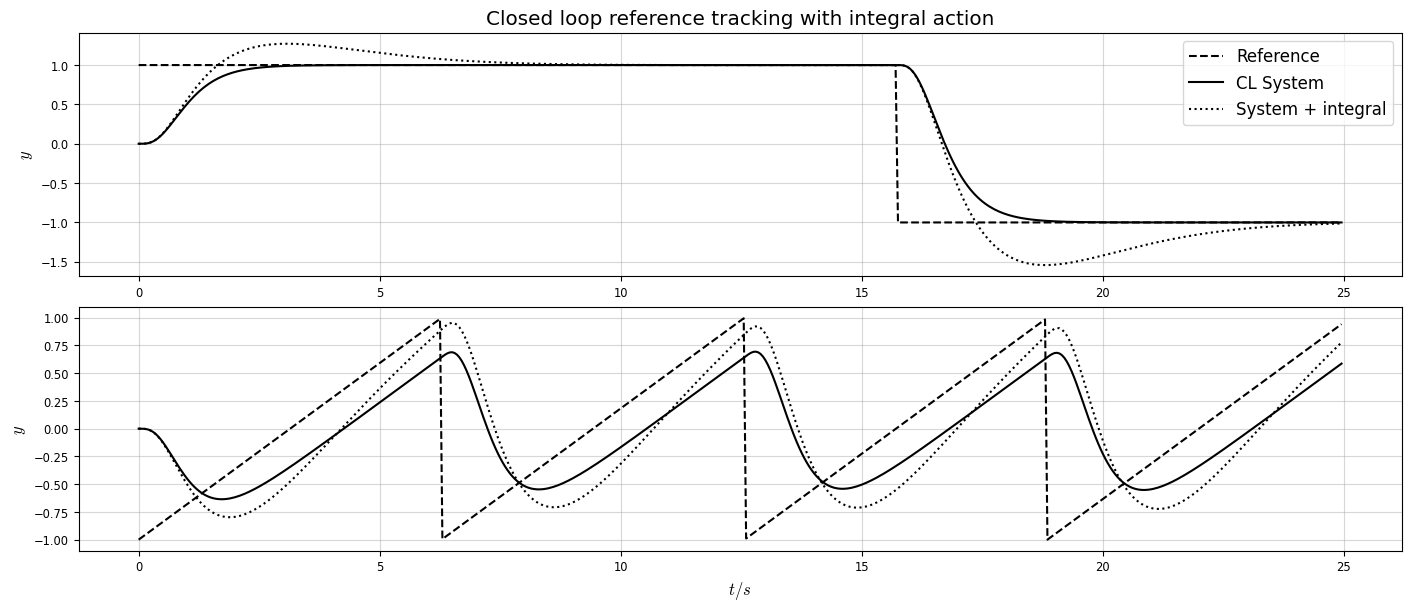

In [8]:
ki = 80. ## CHANGEME

CL_int = cm.ss(np.block([[P_reg.A-P_reg.B@K_reg, -P_reg.B*ki                     ],
                         [P_reg.C,           np.zeros_like(P_reg.C @ P_reg.B)]]), 
               np.vstack((P_reg.B*kf_ref, -1)), 
               np.hstack((P_reg.C, [[0]])), 
               np.zeros([1,1]))

response_sqr_int = cm.forced_response(sysdata=CL_int, T=T_reg, U=sqr_ref)
response_saw_int = cm.forced_response(sysdata=CL_int, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref.time, response_sqr_ref.inputs , 'k--', label="Reference")
ax[0].plot(response_sqr_ref.time, response_sqr_ref.outputs, 'k', label="CL System")
ax[0].plot(response_sqr_int.time, response_sqr_int.outputs, 'k:', label="System + integral")
ax[1].plot(response_saw_ref.time, response_saw_ref.inputs , 'k--', label="Reference")
ax[1].plot(response_saw_ref.time, response_saw_ref.outputs, 'k', label="CL System")
ax[1].plot(response_saw_int.time, response_saw_int.outputs, 'k:', label="System + integral")
ax[0].legend()
ax[0].set(title="Closed loop reference tracking with integral action", ylabel="$y$")
ax[1].set(xlabel="$t/s$", ylabel="$y$")
display(fig)


And now we face dreadful reality and perturb our plant a little!

<IPython.core.display.Javascript object>

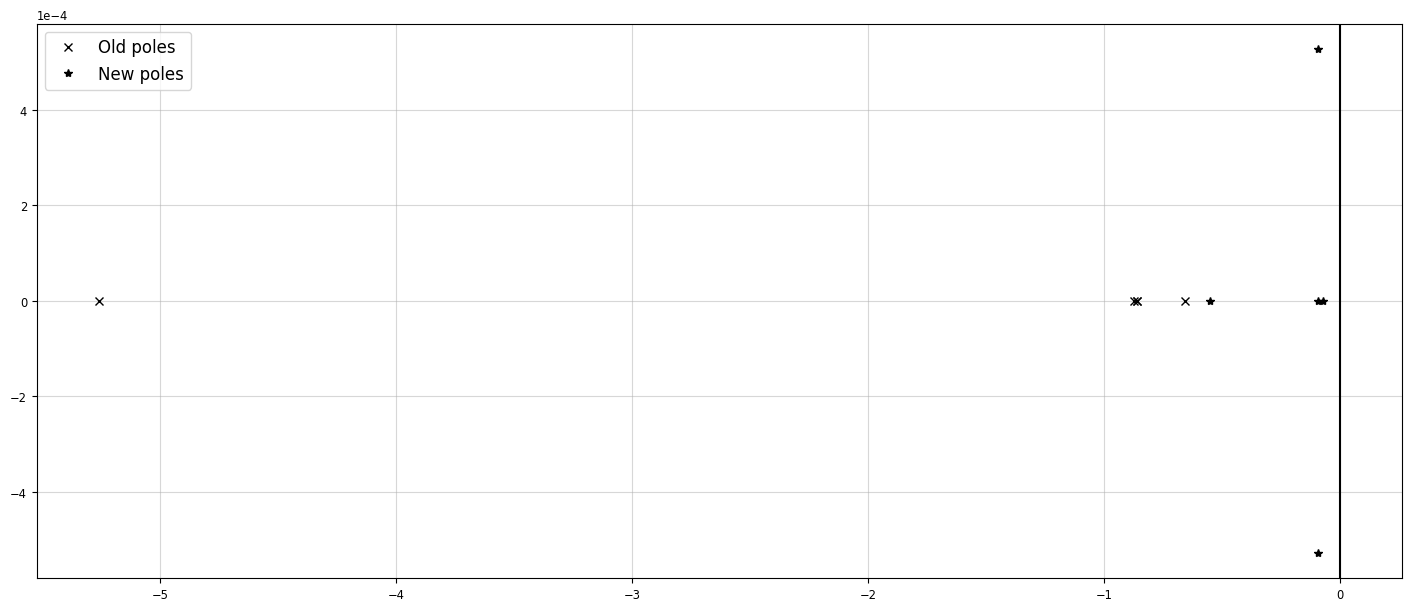

In [9]:
# See https://github.com/python-control/python-control/issues/1188 for the datatype nonsense
ran = np.abs(1. + rng.randn(2) * .3)
poles_pert = [(ran[0] * pole.real + ran[1] * pole.imag*1j).astype(np.complex64) 
                    for pole in P_reg.poles()]

P_pert = cm.ss(cm.zpk(zeros=P_reg.zeros().astype(np.complex64), 
                      poles=poles_pert, 
                      gain=1, dt=0))
P_pert.C *= rng.randn()*.2 + 1.


fig, ax = plt.subplots(1, 1)
ax.axvline(color='k')
s1 = ax.plot(P_reg.poles().real, P_reg.poles().imag, 'kx', label="Old poles")
s2 = ax.plot(P_pert.poles().real, P_pert.poles().imag, 'k*', label="New poles")
ax.legend()
display(fig)


<IPython.core.display.Javascript object>

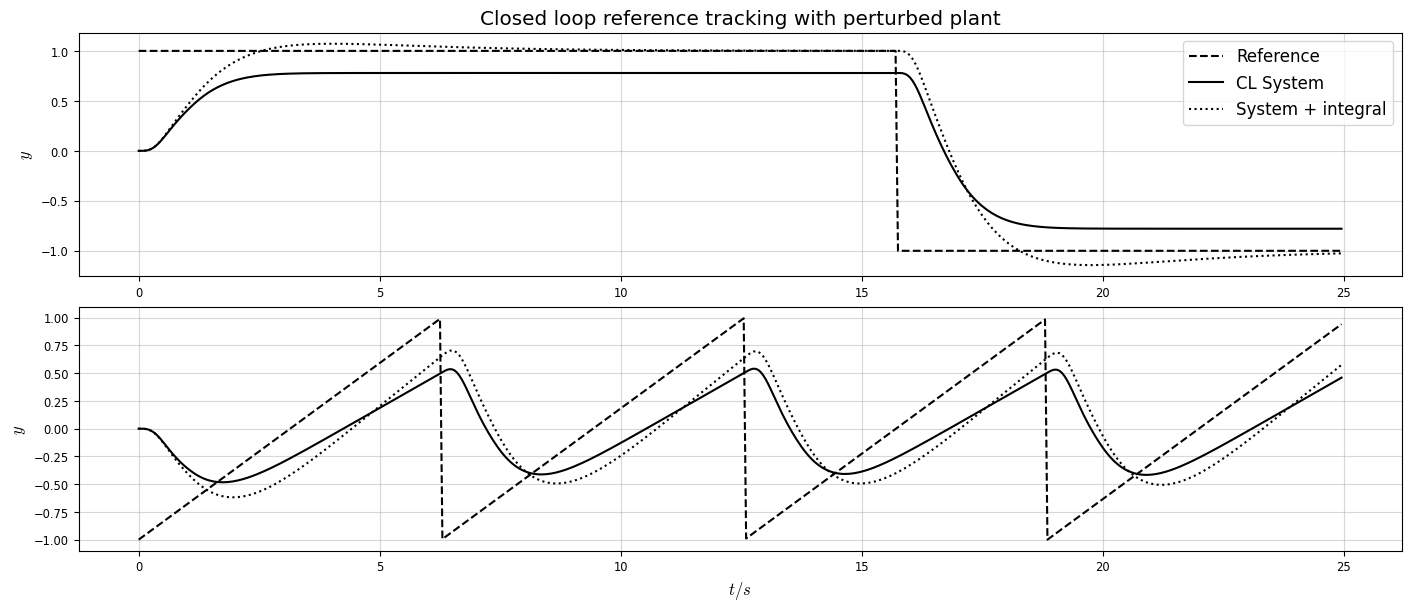

In [10]:
CL_pert = cm.ss(P_pert.A-P_pert.B@K_reg, 
               P_pert.B*kf_ref, 
               P_pert.C, 
               P_pert.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref_pert = cm.forced_response(sysdata=CL_pert, T=T_reg, U=sqr_ref)
response_saw_ref_pert = cm.forced_response(sysdata=CL_pert, T=T_reg, U=saw_ref)

CL_int_pert = cm.ss(np.block([[P_pert.A-P_pert.B@K_reg, -P_pert.B*ki                 ],
                              [P_pert.C,           np.zeros_like(P_pert.C @ P_pert.B)]]), 
               np.vstack((P_pert.B*kf_ref, -1)), 
               np.hstack((P_pert.C, [[0]])), 
               np.zeros([1,1]))

response_sqr_int_pert = cm.forced_response(sysdata=CL_int_pert, T=T_reg, U=sqr_ref)
response_saw_int_pert = cm.forced_response(sysdata=CL_int_pert, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref_pert.time, response_sqr_ref_pert.inputs , 'k--', label="Reference")
ax[0].plot(response_sqr_ref_pert.time, response_sqr_ref_pert.outputs, 'k', label="CL System")
ax[0].plot(response_sqr_int_pert.time, response_sqr_int_pert.outputs, 'k:', label="System + integral")
ax[1].plot(response_saw_ref_pert.time, response_saw_ref_pert.inputs , 'k--', label="Reference")
ax[1].plot(response_saw_ref_pert.time, response_saw_ref_pert.outputs, 'k', label="CL System")
ax[1].plot(response_saw_int_pert.time, response_saw_int_pert.outputs, 'k:', label="System + integral")
ax[0].legend()
ax[0].set(title="Closed loop reference tracking with perturbed plant", ylabel="$y$")
ax[1].set(xlabel="$t/s$", ylabel="$y$")
display(fig)


See how bad the system without the integral action performs? (If not, randomise the plant again...)